## 使用python库

In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from talib.abstract import *
import seaborn as sbn
sbn.set()

## 参数

In [2]:
# Variable
timesteps = 8
batch_size = 16
units = 32
data_dim = 4
div_class = [-0.003, 0.003]
# div_class = [-0.5, -0.3, -0.1, 0.1, 0.3, 0.5]
num_classes = 3

idx_dict = {'上证50': 999987, '沪深300': 300, '中证500': 990905, '中小板指': 399005, '创业板指': 399006}

idxes = []
for name in idx_dict:
    idxes.append(idx_dict[name])
print('idxes: {0}'.format(idxes)) 

idxes: [399006, 399005, 990905, 999987, 300]


## 数据处理

### 数据加载

In [3]:
def data_load():
    data_dir = '../data/'
    day_index1 = data_dir + '1day/index/2000_2009.csv'
    day_index2 = data_dir + '1day/index/2010_2016.csv'
    data1 = pd.read_csv(day_index1,encoding='gbk', parse_dates=['date'])
    data2 = pd.read_csv(day_index2,encoding='gbk', parse_dates=['date'])
    data = pd.concat([data1, data2])
    data.set_index(['code', 'date'], inplace=True)
    return data

In [4]:
data_all = data_load()

### 数据清理

In [5]:
def data_clean(data):
    new_data = pd.DataFrame()
    for column in ['open', 'high', 'low', 'close']:
        new_data[column] = data[column] / 10000.0

    # new_data.dropna(inplace=True)
    return new_data

### 数据转换

#### 转换函数

In [6]:
# 阴阳线
def stick_type(x):
    stick_type = -1
    if x['close'] >= x['open']:
        stick_type = 1
    return stick_type

# 上引线
def up_line(x):
    return x['high'] - x[['open','close']].max()

# 下引线
def down_line(x):
    return -(x[['open','close']].min() - x['low'])

# 实体长度
def body_size(x):
    return x['close'] - x['open']

def range_to_class(x):
    cls = []
    if x >= 0:
        for i in range(num_classes):
            if i == x:
                cls.append(1.0)
            else:
                cls.append(0.0)
    else:
        print(x)
        print("Error: n less than 0")
    return cls

In [7]:
# std_ration = 0.5
# def range_to_class(x):
#     df = pd.DataFrame(index=x.index)
#     df['close'] = x['close']
#     df['next_close'] = df['close'].shift(-1)
#     df['mean'] = df['close'].rolling(window=60, center=False, min_periods=60).mean()
#     df['std'] = df['close'].rolling(window=60, center=False, min_periods=60).std()
#     df.fillna(method='bfill', inplace=True)
#     df['down'] = df['mean'] - std_ration * df['std']
#     df['up'] = df['mean'] + std_ration * df['std']
#     df['class'] = np.nan
#     df.loc[df['next_close'] > df['up'], 'class'] = 2
#     df.loc[df['next_close'] < df['down'], 'class'] = 0
#     cond = (df['next_close'] <= df['up']) & (df['next_close'] >= df['down'])
#     df.loc[cond, 'class'] = 1
#     # last row has no next_close
#     new_data.dropna(inplace=True)
    
#     return df

#### 数据转换

In [8]:
new_dim = 7
data_dim = data_dim + new_dim
std_ration = 0.35
def data_transform(data):
    new_data = pd.DataFrame()
    pre_close = data['close'].shift(1)
    for column in ['open', 'high', 'low', 'close']:
        new_data[column] = (data[column] - pre_close) / pre_close
        
    # add new feature
    new_data['stick_type'] = new_data.apply(stick_type, axis=1)
    new_data['up_line'] = new_data.apply(up_line, axis=1)
    new_data['down_line'] = new_data.apply(down_line, axis=1)
    new_data['close_open'] = new_data.apply(body_size, axis=1)
    
    # macd
    macd = MACD(data.astype({'close': "double"}), price='close')
    new_data = pd.concat([new_data, macd], axis=1)
    new_data.dropna(inplace=True)
    
    # new_data['class'] = new_data.apply(range_to_class, axis=1)
    #new_data.dropna(inplace=True)
    
    df = pd.DataFrame()
    df['close'] = new_data['close']
    df['next_close'] = df['close'].shift(-1)
#     df['mean'] = df['close'].rolling(window=60, center=False, min_periods=60).mean()
#     df['std'] = df['close'].rolling(window=60, center=False, min_periods=60).std()
    df['mean'] = df['close'].mean()
    df['std'] = df['close'].std()
    
    df.fillna(method='bfill', inplace=True)
    df['down'] = df['mean'] - std_ration * df['std']
    df['up'] = df['mean'] + std_ration * df['std']
    df['class'] = np.nan
    df.loc[df['next_close'] > df['up'], 'class'] = 2
    df.loc[df['next_close'] < df['down'], 'class'] = 0
    cond = (df['next_close'] <= df['up']) & (df['next_close'] >= df['down'])
    df.loc[cond, 'class'] = 1
    new_data['class'] = df['class']
    # last row has no next_close
    new_data.dropna(inplace=True)
    
    # new_data['class']= new_data['class'].map(range_to_class)
        
#     # classes
#     new_data['class'] = new_data['close'].shift(-1)
#     # new_data.dropna(inplace=True)
#     new_data.fillna(0, inplace=True)
#     new_data['class']= new_data['class'].map(range_to_class)
        
    # new_data.dropna(inplace=True)
    return new_data

### 获取数据集

In [9]:
def get_data_set(data, codes):
    data_set = {}
    for code in codes:
        query_str = 'code=={0}'.format(code)
        data_match = data.query(query_str)
        data_cleaned = data_clean(data_match)
        data_transformed = data_transform(data_cleaned)
        print('code: {0}, data set len: {1}, start at: {2}, end at: {3}'.format(
            code, len(data_transformed), data_transformed.index[0],data_transformed.index[-1]))
        data_set[code] = data_transformed
    return data_set

In [10]:
data_set = get_data_set(data_all, idxes)

code: 399006, data set len: 1567, start at: (399006, Timestamp('2010-07-21 00:00:00')), end at: (399006, Timestamp('2016-12-29 00:00:00'))
code: 399005, data set len: 2625, start at: (399005, Timestamp('2006-03-21 00:00:00')), end at: (399005, Timestamp('2016-12-29 00:00:00'))
code: 990905, data set len: 2382, start at: (990905, Timestamp('2007-03-21 00:00:00')), end at: (990905, Timestamp('2016-12-29 00:00:00'))
code: 999987, data set len: 3124, start at: (999987, Timestamp('2004-03-01 00:00:00')), end at: (999987, Timestamp('2016-12-29 00:00:00'))
code: 300, data set len: 2814, start at: (300, Timestamp('2005-06-01 00:00:00')), end at: (300, Timestamp('2016-12-29 00:00:00'))


In [11]:
data_set[990905].head()

open      high       low     close  stick_type  \
code   date                                                             
990905 2007-03-21  0.003816  0.017191 -0.003127  0.017181           1   
       2007-03-22  0.003758  0.014110 -0.002216  0.000749          -1   
       2007-03-23  0.000518  0.014204 -0.014035  0.012881           1   
       2007-03-26  0.005883  0.031419  0.005883  0.031419           1   
       2007-03-27  0.002145  0.017162 -0.003320  0.016889           1   

                    up_line  down_line  close_open        macd  macdsignal  \
code   date                                                                  
990905 2007-03-21  0.000009  -0.006943    0.013365  153.861444  155.246046   
       2007-03-22  0.010352  -0.002964   -0.003009  154.535245  155.103886   
       2007-03-23  0.001323  -0.014553    0.012362  156.241908  155.331490   
       2007-03-26  0.000000  -0.000000    0.025536  163.061909  156.877574   
       2007-03-27  0.000272  -0.005466    0.014744  170.574093  159.616878   

                    macdhist  class  
code   date                          
990905 2007-03-21  -1.384602    1.0  
       2007-03-22  -0.568640    2.0  
       2007-03-23   0.910418    2.0  
       2007-03-26   6.184335    2.0  
       2007-03-27  10.957216    0.0

### 数据标准化

In [12]:
def normalize(data):
    new_data = data.copy()
    for column in ['open', 'high', 'low', 'close', 'close_open', 'macd', 'macdsignal', 'macdhist']:
        new_data[column] = preprocessing.scale(new_data[column])
        
    updown_line_values = new_data.loc[:,['up_line', 'down_line']].values
    updown_line_values_norm = preprocessing.scale(updown_line_values.reshape((-1,1))).reshape((-1, 2))
    updown_df = pd.DataFrame(index=new_data.index, columns=['up_line', 'down_line'], data=updown_line_values_norm)
    new_data['up_line'] = updown_df['up_line']
    new_data['down_line'] = updown_df['down_line']
        
    return new_data

In [13]:
data_set_norm = {}
for code in data_set:
    data_set_norm[code] = normalize(data_set[code])

In [14]:
data_set_norm[990905].head()

open      high       low     close  stick_type  \
code   date                                                             
990905 2007-03-21  0.602567  0.488264  0.595657  0.766097           1   
       2007-03-22  0.595456  0.250186  0.648900  0.008084          -1   
       2007-03-23  0.201797  0.257447 -0.041743  0.567706           1   
       2007-03-26  0.853752  1.587776  1.122149  1.422842           1   
       2007-03-27  0.399542  0.486022  0.584350  0.752623           1   

                    up_line  down_line  close_open      macd  macdsignal  \
code   date                                                                
990905 2007-03-21  0.122132  -0.772651    0.575542  0.970548    1.041022   
       2007-03-22  1.453296  -0.260574   -0.233408  0.975152    1.039987   
       2007-03-23  0.291246  -1.752101    0.525985  0.986812    1.041643   
       2007-03-26  0.120941   0.120941    1.176811  1.033410    1.052893   
       2007-03-27  0.155990  -0.582541    0.643646  1.084737    1.072826   

                   macdhist  class  
code   date                         
990905 2007-03-21 -0.022535    1.0  
       2007-03-22 -0.004502    2.0  
       2007-03-23  0.028186    2.0  
       2007-03-26  0.144743    2.0  
       2007-03-27  0.250227    0.0

### 数据分割

In [15]:
def split_data(data, date, timesteps, batch_size):
    min_num = int(batch_size) * int(timesteps)
    
    train_query_str = 'date <= "{}"'.format(date)
    test_query_str = 'date > "{}"'.format(date)
    
    train = data.query(train_query_str)
    test = data.query(test_query_str)
    
    train_size = len(train)
    test_size = len(test)
    print('split set to train size: {0}, test size: {1}'.format(train_size, test_size))
    
    train_batchs = int(train_size / min_num)
    test_batchs = int(test_size / min_num)
    
    if train_batchs > 0:
        train = train[-(train_batchs * min_num + 1):-1]
    else:
        train = None

    if test_batchs > 0:
        test = test[0:test_batchs * min_num]
    else:
        test = None
    
    print("train set len: {0}, start at {1}, end at {2}".format(len(train), train.index[0], train.index[-1]))
    print("test set len: {0}, start at {1}, end at {2}".format(len(test), test.index[0], test.index[-1])) 
    return train, test

In [16]:
df_train_set = {}
df_test_set = {}

for code in data_set_norm:
    print('spliting code: {0}'.format(code))
    train, test = split_data(data_set_norm[code], '20151214', timesteps=timesteps, batch_size=batch_size)
    df_train_set[code] = train
    df_test_set[code] = test

spliting code: 990905
split set to train size: 2126, test size: 256
train set len: 2048, start at (990905, Timestamp('2007-07-13 00:00:00')), end at (990905, Timestamp('2015-12-11 00:00:00'))
test set len: 256, start at (990905, Timestamp('2015-12-15 00:00:00')), end at (990905, Timestamp('2016-12-29 00:00:00'))
spliting code: 999987
split set to train size: 2868, test size: 256
train set len: 2816, start at (999987, Timestamp('2004-05-18 00:00:00')), end at (999987, Timestamp('2015-12-11 00:00:00'))
test set len: 256, start at (999987, Timestamp('2015-12-15 00:00:00')), end at (999987, Timestamp('2016-12-29 00:00:00'))
spliting code: 300
split set to train size: 2558, test size: 256
train set len: 2432, start at (300, Timestamp('2005-12-08 00:00:00')), end at (300, Timestamp('2015-12-11 00:00:00'))
test set len: 256, start at (300, Timestamp('2015-12-15 00:00:00')), end at (300, Timestamp('2016-12-29 00:00:00'))
spliting code: 399005
split set to train size: 2369, test size: 256
train

In [17]:
df_train_set[990905].columns

Index(['open', 'high', 'low', 'close', 'stick_type', 'up_line', 'down_line',
       'close_open', 'macd', 'macdsignal', 'macdhist', 'class'],
      dtype='object')

<IPython.core.display.Javascript object>


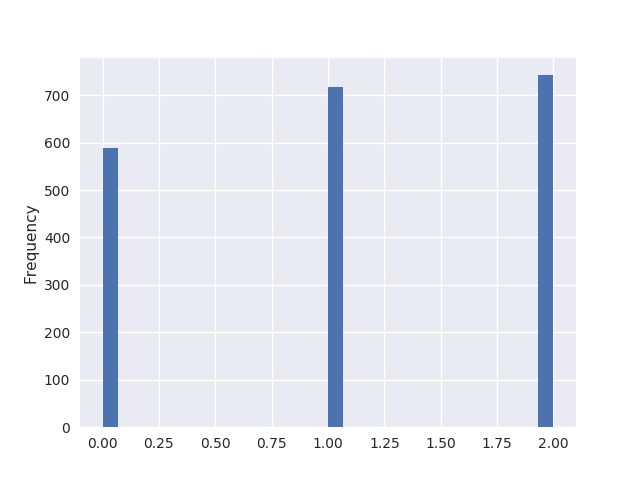

In [18]:
df_train_set[990905]['class'].plot.hist(bins=30)
# df_test_set[990905]['class'].plot.hist(bins=30)

### 数据重整

In [19]:
def data_reform(data, batch_size, timesteps):
    data['class']= data['class'].map(range_to_class)
    data_values = data.values
    
    print("shape: {0}".format(data_values.shape))
    size = len(data_values)
    if size % (int(batch_size) * int(timesteps)) != 0:
        print("data size not match, size: {0}, batch_size: {1}, timesteps: {2}".format(size, batch_size, timesteps))
        return None, None
   
    X, Y0 = data_values[:, :-1], data_values[:, -1]
    
    X = X.reshape((-1, timesteps, X.shape[1]))
    
    Y = np.array([np.array(y) for y in Y0])
       
    Y = Y.reshape((-1, timesteps, Y.shape[1]))
    
    print("X.shape: {0} Y.shape: {1}".format(X.shape, Y.shape))
    
    return X, Y

In [20]:
train_set = {}
test_set = {}

for code in df_train_set:
    train_set[code] = data_reform(df_train_set[code], batch_size, timesteps)
                                  
for code in df_test_set:
    test_set[code] = data_reform(df_test_set[code], batch_size, timesteps)

shape: (2048, 12)
X.shape: (64, 32, 11) Y.shape: (64, 32, 3)
shape: (2816, 12)
X.shape: (88, 32, 11) Y.shape: (88, 32, 3)
shape: (2432, 12)
X.shape: (76, 32, 11) Y.shape: (76, 32, 3)
shape: (2304, 12)
X.shape: (72, 32, 11) Y.shape: (72, 32, 3)
shape: (1280, 12)
X.shape: (40, 32, 11) Y.shape: (40, 32, 3)
shape: (256, 12)
X.shape: (8, 32, 11) Y.shape: (8, 32, 3)
shape: (256, 12)
X.shape: (8, 32, 11) Y.shape: (8, 32, 3)
shape: (256, 12)
X.shape: (8, 32, 11) Y.shape: (8, 32, 3)
shape: (256, 12)
X.shape: (8, 32, 11) Y.shape: (8, 32, 3)
shape: (256, 12)
X.shape: (8, 32, 11) Y.shape: (8, 32, 3)


## 数据分析

In [ ]:
data_all = data_load()

In [ ]:
idx_dict = {'上证50': 999987, '沪深300': 300, '中证500': 990905, '中小板指': 399005, '创业板指': 399006}

In [ ]:
# 确认指数代码
for idx_name in idx_dict:
    print("name: {0}".format(idx_name))
    Id = data_all[data_all['name'] == idx_name].index.get_level_values('code').unique()
    print("Id: {0}".format(Id))

In [ ]:
years = pd.date_range('1/1/2006', periods=11, freq='A')

In [ ]:
def data_stat(data, years, idx_dict):
    idxes_des = pd.DataFrame()
    for name in idx_dict:
        # print(name)
        code = idx_dict[name]
        query_code = 'code=={0}'.format(code)
        # print("query code: {0}".format(query_code))
        data_code = data.query(query_code)
        data_code_c = data_clean(data_code)
        data_code_t = data_transform(data_code_c)
        idx_des = pd.DataFrame()
        for year in years:
            end_date = year
            begin_date  = year.replace(month=1, day=1)
            query_date = 'date>"{0}" & date < "{1}"'.format(begin_date, end_date)
            # print("query date: {0}".format(query_date))
            data_code_year = data_code_t.query(query_date)
            describe = data_code_year.close.describe()
            df_describe = describe.to_frame().reset_index()
            df_describe['date'] = year
            idx_des = pd.concat([idx_des, df_describe])
        idx_des = idx_des.pivot(index='date', columns='index', values='close')    
        idx_des['code'] = code
        idxes_des = pd.concat([idxes_des, idx_des])
    return idxes_des

In [ ]:
data_stat = data_stat(data_all, years, idx_dict)

In [ ]:
data_stat_d = data_stat.drop(['count', 'min', 'max', 'std'],axis=1).dropna()

In [ ]:
t = data_stat_d.reset_index().set_index(['code', 'date'])
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 6))
t.loc[999987].plot(ax=axes[0, 0])
t.loc[300].plot(ax=axes[0, 1])
t.loc[990905].plot(ax=axes[1, 0])
t.loc[399005].plot(ax=axes[1, 1])
t.loc[399006].plot(ax=axes[2, 0])

## 模型

In [21]:
batch_size, timesteps, data_dim

(4, 32, 11)

In [29]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.layers import LSTM, Dense, Dropout, BatchNormalization, Activation

units = 32
model = Sequential()
# input layer
# activation='relu' 
# dropout=0.5
# kernel_initializer="uniform"
model.add(LSTM(units, stateful=True, return_sequences=True, batch_input_shape=(batch_size, timesteps, data_dim)))
# hidden layer
model.add(LSTM(units, return_sequences=True, stateful=True, dropout=0.5))
model.add(LSTM(units, return_sequences=True, stateful=True, dropout=0.5))
model.add(LSTM(units, return_sequences=True, stateful=True, dropout=0.5))

# 回归问题
# # output layer
# # model.add(Dense(no_classes, activation='softmax'))
# model.add(Dense(1, activation='sigmoid')) # or sigmoid?
# # model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
# model.compile(optimizer='RMSProp', loss='mse') #mse

# 分类问题
# output layer
model.add(Dense(num_classes, activation='softmax'))
# model.add(Dense(num_classes, kernel_initializer="uniform"))
# model.add(BatchNormalization())
# model.add(Activation('softmax'))

from keras.optimizers import SGD, Adam, RMSprop
model.compile(optimizer=RMSprop(0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (4, 32, 32)               5632      
_________________________________________________________________
lstm_11 (LSTM)               (4, 32, 32)               8320      
_________________________________________________________________
lstm_12 (LSTM)               (4, 32, 32)               8320      
_________________________________________________________________
lstm_13 (LSTM)               (4, 32, 32)               8320      
_________________________________________________________________
dense_4 (Dense)              (4, 32, 3)                99        
Total params: 30,691
Trainable params: 30,691
Non-trainable params: 0
_________________________________________________________________


## 数据集

### 测试集

In [ ]:
def get_data_set(data, codes):
    data_set = {}
    for code in codes:
        query_str = 'code=={0}'.format(code)
        data_match = data.query(query_str)
        data_cleaned = data_clean(data_match)
        data_transformed = data_transform(data_cleaned)
        print(data_transformed.index[0])
        print(data_transformed.index[-1])
        data_set[code] = data_transformed
    return data_set

data_set = get_data_set(data_all, ['990905', '999987'])

In [ ]:
data_set['990905'].head()

In [ ]:
df = range_to_class(data_set['990905'])

In [ ]:
df.head()

In [ ]:
# df['class'].plot.hist(bins=30)

In [ ]:
data_set_norm = normalize(data_set)

In [ ]:
data_set['990905'].columns

In [ ]:
data_set_norm['990905'].low.plot.hist(bins=30)
plt.show()

In [ ]:
data_set_norm['990905']

In [ ]:
zz500_close = data_set['990905']['close']

In [ ]:
mean = zz500_close.rolling(window=60, center=False, min_periods=60).mean()
std = zz500_close.rolling(window=60, center=False, min_periods=60).std()

In [ ]:
print(zz500_close.head(70).tail(10))
print(mean.head(70).tail(10))
print(std.head(70).tail(10))

In [ ]:
xxx['990905'].down_line.plot.hist(bins=30)
xxx['990905'].up_line.plot.hist(bins=30)

In [ ]:
datx['990905'].down_line.max()

In [ ]:
query_str = 'code=={0}'.format(300)
hs300 = data_all.query(query_str)
hs300_close = hs300['close'] / 10000.0

In [ ]:
hs300_close.head()

In [ ]:
mean = hs300_close.rolling(window=60, center=False, min_periods=60).mean()
std = hs300_close.rolling(window=60, center=False, min_periods=60).std()

In [ ]:
mean.tail(10)

In [ ]:
std.tail(10)

In [ ]:
hs300_close.tail(10)

In [ ]:
test_codes = ['990905', '999987']
test_date_query = 'date>"20141120"'

In [ ]:
raw_test_set = get_data_set(data_all, test_codes, test_date_query, timesteps, batch_size)

In [ ]:
#raw_test_set['999987'].describe()

In [ ]:
test_set = {}
for code in raw_test_set:
    test_set[code] = data_reform(normalize(raw_test_set[code]).values, batch_size, timesteps)

In [ ]:
idxes = data_all.index.get_level_values('code').unique()

### 训练集

In [ ]:
train_map = {'上证50': 999987, '沪深300': 300, '中证500': 990905, '中小板指': 399005, '创业板指': 399006}

In [ ]:
# train sets
train_codes = []
for key in train_map:
    train_codes.append(train_map[key])
    
train_date_query = 'date<"20150101"'

raw_train_set = get_data_set(data_all, train_codes, train_date_query, timesteps, batch_size)

In [ ]:
raw_train_set[300].head()

In [ ]:
train_set = {}
for code in raw_train_set:
    train_set[code] = data_reform(normalize(raw_train_set[code]).values, batch_size, timesteps)

## 训练

In [30]:
from influxdb import InfluxDBClient
from influxdb import SeriesHelper
host = '183.136.205.102'
port = 38086
user = 'root'
password = 'root'
dbname = 'chq'

myclient = InfluxDBClient(host, port, user, password, dbname)

In [31]:
trainid = 6
class MySeriesHelper(SeriesHelper):
    # Meta class stores time series helper configuration.
    class Meta:
        # The client should be an instance of InfluxDBClient.
        client = myclient
        # The series name must be a string. Add dependent fields/tags in curly brackets.
        series_name = 'deeplearning.train' + str(trainid)
        # Defines all the fields in this time series.
        fields = ['loss', 'acc']
        # Defines all the tags for the series.
        tags = ['dtype', 'code', 'epoch']
        # Defines the number of data points to store prior to writing on the wire.
        bulk_size = 5
        # autocommit must be set to True when using bulk_size
        autocommit = True

In [32]:
epochs =2000
def train(model, train_set, test_set, epochs, batch_size):
# def train():
    for e in range(epochs):
        for code in train_set:
            print("epochs: {0}, code: {1}".format(e, code))
            train_X, train_Y = train_set[code]
            # print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)
            # history = model.fit(train_X, train_Y, epochs=100, batch_size=batch_size, validation_data=(test_X, test_Y), verbose=1, shuffle=False)
            history = model.fit(train_X, train_Y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
            model.reset_states()  
            # result = {'type': 'train', 'code': code, 'train_loss': (e, history.history['loss'][-1]), 'train_acc': (e, history.history['acc'][-1])}
            MySeriesHelper(dtype="train", code=code, epoch = e, loss=history.history['loss'][-1], acc= history.history['acc'][-1])
            # print(result)
        MySeriesHelper.commit()
            # yield result
        for code in test_set:
            test_X1, test_Y1 = test_set[code]
            loss_and_metrics = model.evaluate(test_X1, test_Y1, batch_size=batch_size)
            model.reset_states()
            # result = {'type': 'test', 'code': code, 'test_loss': (e, loss_and_metrics[0]), 'test_acc': (e, loss_and_metrics[1])}
            MySeriesHelper(dtype="test", code=code, epoch = e, loss=loss_and_metrics[0], acc= loss_and_metrics[1])
            # print(result)
        MySeriesHelper.commit()
            # yield result
                # print("==================================")
                # print("loss_and_metrics: {0}".format(loss_and_metrics))
                # print("==================================")

#     def data_gen(t=0):
#         cnt = 0
#         while cnt < 1000:
#             cnt += 1
#             t += 0.1
#             yield t, np.sin(2*np.pi*t) * np.exp(-t/10.)
# ani = animation.FuncAnimation(fig, run, train, repeat=False, init_func=init)
# plt.show()


In [ ]:
train(model, train_set, test_set, epochs, batch_size)

epochs: 0, code: 990905
epochs: 0, code: 999987
epochs: 0, code: 300
epochs: 0, code: 399005
epochs: 0, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 1, code: 990905
epochs: 1, code: 999987
epochs: 1, code: 300
epochs: 1, code: 399005
epochs: 1, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 2, code: 990905
epochs: 2, code: 999987
epochs: 2, code: 300
epochs: 2, code: 399005
epochs: 2, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 3, code: 990905
epochs: 3, code: 999987
epochs: 3, code: 300
epochs: 3, code: 399005
epochs: 3, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 4, code: 990905
epochs: 4, code: 999987
epochs: 4, code: 300
epochs: 4, code: 399005
epochs: 4, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 5, code: 990905
epochs: 5, code: 999987
epochs: 5, code: 300
epochs: 5, code: 399005
epochs: 5, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 6, code: 99090

epochs: 49, code: 999987
epochs: 49, code: 300
epochs: 49, code: 399005
epochs: 49, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 50, code: 990905
epochs: 50, code: 999987
epochs: 50, code: 300
epochs: 50, code: 399005
epochs: 50, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 51, code: 990905
epochs: 51, code: 999987
epochs: 51, code: 300
epochs: 51, code: 399005
epochs: 51, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 52, code: 990905
epochs: 52, code: 999987
epochs: 52, code: 300
epochs: 52, code: 399005
epochs: 52, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 53, code: 990905
epochs: 53, code: 999987
epochs: 53, code: 300
epochs: 53, code: 399005
epochs: 53, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 54, code: 990905
epochs: 54, code: 999987
epochs: 54, code: 300
epochs: 54, code: 399005
epochs: 54, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 55, code:

4/8 [==============>...............] - ETA: 0sepochs: 98, code: 990905
epochs: 98, code: 999987
epochs: 98, code: 300
epochs: 98, code: 399005
epochs: 98, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 99, code: 990905
epochs: 99, code: 999987
epochs: 99, code: 300
epochs: 99, code: 399005
epochs: 99, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 100, code: 990905
epochs: 100, code: 999987
epochs: 100, code: 300
epochs: 100, code: 399005
epochs: 100, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 101, code: 990905
epochs: 101, code: 999987
epochs: 101, code: 300
epochs: 101, code: 399005
epochs: 101, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 102, code: 990905
epochs: 102, code: 999987
epochs: 102, code: 300
epochs: 102, code: 399005
epochs: 102, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 103, code: 990905
epochs: 103, code: 999987
epochs: 103, code: 300
epochs: 103, code: 39900

4/8 [==============>...............] - ETA: 0sepochs: 145, code: 990905
epochs: 145, code: 999987
epochs: 145, code: 300
epochs: 145, code: 399005
epochs: 145, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 146, code: 990905
epochs: 146, code: 999987
epochs: 146, code: 300
epochs: 146, code: 399005
epochs: 146, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 147, code: 990905
epochs: 147, code: 999987
epochs: 147, code: 300
epochs: 147, code: 399005
epochs: 147, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 148, code: 990905
epochs: 148, code: 999987
epochs: 148, code: 300
epochs: 148, code: 399005
epochs: 148, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 149, code: 990905
epochs: 149, code: 999987
epochs: 149, code: 300
epochs: 149, code: 399005
epochs: 149, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 150, code: 990905
epochs: 150, code: 999987
epochs: 150, code: 300
epochs: 150, c

epochs: 192, code: 999987
epochs: 192, code: 300
epochs: 192, code: 399005
epochs: 192, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 193, code: 990905
epochs: 193, code: 999987
epochs: 193, code: 300
epochs: 193, code: 399005
epochs: 193, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 194, code: 990905
epochs: 194, code: 999987
epochs: 194, code: 300
epochs: 194, code: 399005
epochs: 194, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 195, code: 990905
epochs: 195, code: 999987
epochs: 195, code: 300
epochs: 195, code: 399005
epochs: 195, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 196, code: 990905
epochs: 196, code: 999987
epochs: 196, code: 300
epochs: 196, code: 399005
epochs: 196, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 197, code: 990905
epochs: 197, code: 999987
epochs: 197, code: 300
epochs: 197, code: 399005
epochs: 197, code: 399006
4/8 [==============>..............

4/8 [==============>...............] - ETA: 0sepochs: 239, code: 990905
epochs: 239, code: 999987
epochs: 239, code: 300
epochs: 239, code: 399005
epochs: 239, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 240, code: 990905
epochs: 240, code: 999987
epochs: 240, code: 300
epochs: 240, code: 399005
epochs: 240, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 241, code: 990905
epochs: 241, code: 999987
epochs: 241, code: 300
epochs: 241, code: 399005
epochs: 241, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 242, code: 990905
epochs: 242, code: 999987
epochs: 242, code: 300
epochs: 242, code: 399005
epochs: 242, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 243, code: 990905
epochs: 243, code: 999987
epochs: 243, code: 300
epochs: 243, code: 399005
epochs: 243, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 244, code: 990905
epochs: 244, code: 999987
epochs: 244, code: 300
epochs: 244, c

epochs: 286, code: 999987
epochs: 286, code: 300
epochs: 286, code: 399005
epochs: 286, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 287, code: 990905
epochs: 287, code: 999987
epochs: 287, code: 300
epochs: 287, code: 399005
epochs: 287, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 288, code: 990905
epochs: 288, code: 999987
epochs: 288, code: 300
epochs: 288, code: 399005
epochs: 288, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 289, code: 990905
epochs: 289, code: 999987
epochs: 289, code: 300
epochs: 289, code: 399005
epochs: 289, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 290, code: 990905
epochs: 290, code: 999987
epochs: 290, code: 300
epochs: 290, code: 399005
epochs: 290, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 291, code: 990905
epochs: 291, code: 999987
epochs: 291, code: 300
epochs: 291, code: 399005
epochs: 291, code: 399006
4/8 [==============>..............

epochs: 333, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 334, code: 990905
epochs: 334, code: 999987
epochs: 334, code: 300
epochs: 334, code: 399005
epochs: 334, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 335, code: 990905
epochs: 335, code: 999987
epochs: 335, code: 300
epochs: 335, code: 399005
epochs: 335, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 336, code: 990905
epochs: 336, code: 999987
epochs: 336, code: 300
epochs: 336, code: 399005
epochs: 336, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 337, code: 990905
epochs: 337, code: 999987
epochs: 337, code: 300
epochs: 337, code: 399005
epochs: 337, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 338, code: 990905
epochs: 338, code: 999987
epochs: 338, code: 300
epochs: 338, code: 399005
epochs: 338, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 339, code: 990905
epochs: 339, code: 999987
epochs: 339

4/8 [==============>...............] - ETA: 0sepochs: 381, code: 990905
epochs: 381, code: 999987
epochs: 381, code: 300
epochs: 381, code: 399005
epochs: 381, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 382, code: 990905
epochs: 382, code: 999987
epochs: 382, code: 300
epochs: 382, code: 399005
epochs: 382, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 383, code: 990905
epochs: 383, code: 999987
epochs: 383, code: 300
epochs: 383, code: 399005
epochs: 383, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 384, code: 990905
epochs: 384, code: 999987
epochs: 384, code: 300
epochs: 384, code: 399005
epochs: 384, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 385, code: 990905
epochs: 385, code: 999987
epochs: 385, code: 300
epochs: 385, code: 399005
epochs: 385, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 386, code: 990905
epochs: 386, code: 999987
epochs: 386, code: 300
epochs: 386, c

epochs: 428, code: 999987
epochs: 428, code: 300
epochs: 428, code: 399005
epochs: 428, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 429, code: 990905
epochs: 429, code: 999987
epochs: 429, code: 300
epochs: 429, code: 399005
epochs: 429, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 430, code: 990905
epochs: 430, code: 999987
epochs: 430, code: 300
epochs: 430, code: 399005
epochs: 430, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 431, code: 990905
epochs: 431, code: 999987
epochs: 431, code: 300
epochs: 431, code: 399005
epochs: 431, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 432, code: 990905
epochs: 432, code: 999987
epochs: 432, code: 300
epochs: 432, code: 399005
epochs: 432, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 433, code: 990905
epochs: 433, code: 999987
epochs: 433, code: 300
epochs: 433, code: 399005
epochs: 433, code: 399006
4/8 [==============>..............

epochs: 475, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 476, code: 990905
epochs: 476, code: 999987
epochs: 476, code: 300
epochs: 476, code: 399005
epochs: 476, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 477, code: 990905
epochs: 477, code: 999987
epochs: 477, code: 300
epochs: 477, code: 399005
epochs: 477, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 478, code: 990905
epochs: 478, code: 999987
epochs: 478, code: 300
epochs: 478, code: 399005
epochs: 478, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 479, code: 990905
epochs: 479, code: 999987
epochs: 479, code: 300
epochs: 479, code: 399005
epochs: 479, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 480, code: 990905
epochs: 480, code: 999987
epochs: 480, code: 300
epochs: 480, code: 399005
epochs: 480, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 481, code: 990905
epochs: 481, code: 999987
epochs: 481

4/8 [==============>...............] - ETA: 0sepochs: 523, code: 990905
epochs: 523, code: 999987
epochs: 523, code: 300
epochs: 523, code: 399005
epochs: 523, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 524, code: 990905
epochs: 524, code: 999987
epochs: 524, code: 300
epochs: 524, code: 399005
epochs: 524, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 525, code: 990905
epochs: 525, code: 999987
epochs: 525, code: 300
epochs: 525, code: 399005
epochs: 525, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 526, code: 990905
epochs: 526, code: 999987
epochs: 526, code: 300
epochs: 526, code: 399005
epochs: 526, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 527, code: 990905
epochs: 527, code: 999987
epochs: 527, code: 300
epochs: 527, code: 399005
epochs: 527, code: 399006
4/8 [==============>...............] - ETA: 0sepochs: 528, code: 990905
epochs: 528, code: 999987
epochs: 528, code: 300
epochs: 528, c

In [ ]:
# def data_gen(t=0):
#     cnt = 0
#     while cnt < 1000:
#         cnt += 1
#         t += 0.1
#         yield t, np.sin(2*np.pi*t) * np.exp(-t/10.)

In [ ]:
# ani = animation.FuncAnimation(fig, run, data_gen, repeat=False, init_func=init)
# plt.show()

In [ ]:
# train(model, train_set, test_set, 100, batch_size)

In [ ]:
plt.show()

In [ ]:
train()

In [ ]:
# history = model.fit(train_X, train_Y, epochs=100, batch_size=batch_size, validation_data=(test_X, test_Y), verbose=1, shuffle=False)

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

In [ ]:
predict_Y=model.predict(x=test_X1,batch_size=batch_size)

In [ ]:
predict_Y.shape

In [ ]:
predict_value = np.argmax(predict_Y,axis=2)

In [ ]:
predict_value.shape

In [ ]:
test_set = idx300n.iloc[1800:2400, :].copy()

In [ ]:
test_t2.head()

In [ ]:
def class_argmax(x):
    return np.argmax(x)

In [ ]:
test_set = test_t1

In [ ]:
test_set['class']= test_set['class'].map(class_argmax)

In [ ]:
test_set.head()

In [ ]:
cmp_predict = pd.DataFrame()
cmp_predict['class'] = test_set['class']

In [ ]:
cmp_predict['predict_class'] = predict_value.reshape((-1, ))

In [ ]:
cmp_predict['close'] = test_t2.loc[cmp_predict.index, 'close']

In [ ]:
cmp_predict['diff'] = cmp_predict['predict_class'] - cmp_predict['class']

In [ ]:
cmp_predict.head()

In [ ]:
cmp_predict=cmp_predict.reset_index()

In [ ]:
cmp_predict = cmp_predict.reset_index()

In [ ]:
cmp_predict.head()

In [ ]:
def color(x):
    c = 'm'
    if x < 0:
        c = 'g'
    elif x > 0:
        c = 'r'
    else:
        c = 'b'
    return c
cmp_predict['color'] = cmp_predict['diff'].map(color)

In [ ]:
cmp_predict.plot(kind='scatter', x='index', y='close', s=60, c=cmp_predict.color, figsize=(21, 7))

In [ ]:
test_t2['close'].head(600).plot.hist( bins=30, figsize=(21, 7))

In [ ]:
cmp_predict.tail()

In [ ]:
cmp_predict['predict_class'].plot.hist()

In [ ]:
cmp_predict['class'].plot.hist()

In [ ]:
cmp_predict['next_close'] = cmp_predict['close'].shift(-1)

In [ ]:
cmp_predict['profit'] = cmp_predict['next_close'] - cmp_predict['close']

In [ ]:
cmp_predict.head()

In [ ]:
def predict_profit(x):
    profit = 0
    if x['predict_class'] == 2:
        profit = x['profit']
    elif x['predict_class'] == 0:
        profit = -x['profit']
    else:
        profit = 0
    return profit
cmp_predict['predict_profit'] = cmp_predict.apply(predict_profit, axis=1)

In [ ]:
cmp_predict['predict_profit'].cumsum().plot(figsize=(21, 7))

In [ ]:
cmp_predict.head(400).tail()

In [ ]:
cmp_predict.head()

In [ ]:
cmp_predict[cmp_predict['predict_class']==2]['predict_profit'].cumsum().plot(figsize=(21, 7))

In [ ]:
cmp_predict[cmp_predict['predict_class']==0]['predict_profit'].cumsum().plot(figsize=(21, 7))

## 性能评估

### 类预测比较

### 类分布

In [ ]:
# column: true_class predict_class
def class_compare(df):
    return pd.crosstab(df.true_class, df.predict_class, margins=True) 

### 利润

In [ ]:
# column: close signal
def portfolio_return_ration(df, direction="both"):
    def profit(x):
        # 归一化
        x[x['signal'] < -1]['signal'] = -1
        x[x['signal'] > 1]['signal'] = 1

        if direction == "long":
            x[x['signal'] < 0]['signal'] = 0
        elif direction == "short":
            x[x['signal'] > 0]['signal'] = 0
            
        x['profit'] = x['diff'] * x['signal']
        return x

    df_tmp = pd.DataFrame()
    pre_close = df['close'].shift(1)
    df_tmp['diff'] =  df['close'] - pre_close
    df_tmp['signal'] = df['signal']
    
    df_tmp['profit'] = df.apply(profit, axis=1)
    return (df_tmp['profit']+1).cumprod()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 20, 100)
y = np.sin(x)
z = x + 20 * y

scaled_z = (x - x.min())
colors = plt.cm.coolwarm(x)

plt.scatter(x, y, marker='+', edgecolors=colors, s=150, linewidths=4)
plt.show()